In [32]:
import os
import pandas as pd
import numpy as np

os.chdir("C:\\Users\\StuartWilson\\Documents\\Portfolio\\NEISS")

In [33]:
neiss = pd.read_csv('Data\\neiss.csv')
neiss = neiss.sample(frac=1)
print(neiss.shape)
print(neiss.columns)

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11,12,13,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(1841588, 27)
Index(['Unnamed: 0', 'CPSC_Case_Number', 'Treatment_Date', 'Age', 'Sex',
       'Race', 'Other_Race', 'Hispanic', 'Body_Part', 'Diagnosis',
       'Other_Diagnosis', 'Body_Part_2', 'Diagnosis_2', 'Other_Diagnosis_2',
       'Disposition', 'Location', 'Fire_Involvement', 'Alcohol', 'Drug',
       'Narrative', 'Stratum', 'PSU', 'Weight', 'Product', 'Product_2',
       'Product_3', 'Year'],
      dtype='object')


In [34]:
#show how many 'not recorded' in location column
neiss['Location'].value_counts(normalize=True)

Home                             0.439636
Not recorded                     0.283534
Place of recreation or sports    0.130473
Other public property            0.070278
School/Daycare                   0.053731
Street or highway                0.021715
Farm/ranch                       0.000347
Mobile/Manufactured home         0.000212
Industrial                       0.000074
Name: Location, dtype: float64

In [35]:
neiss['Narrative'].head(3)


1328371    44YF ETOH INTOX'D IN AN ARGUMENT C FAMLY MEMBE...
924877     76YOF EXERCISING ON A TREADMILL AND FELL OFF S...
1025502    15 YO M, C/O CUT TO FOREHEAD S/P FALLING OFF H...
Name: Narrative, dtype: object

In [36]:
#remove unnecessary columns
neiss_clf = neiss[['Location', 'Narrative']]
neiss_clf.head()

Location                                          Narrative
1328371          Home  44YF ETOH INTOX'D IN AN ARGUMENT C FAMLY MEMBE...
924877   Not recorded  76YOF EXERCISING ON A TREADMILL AND FELL OFF S...
1025502  Not recorded  15 YO M, C/O CUT TO FOREHEAD S/P FALLING OFF H...
330042           Home  42YOF FELL GETTING INTO BED AND SUSTAINED A CO...
891894           Home  27YOF TRIPPED OVER CHILDS TOY AND LANDED ONTO ...

In [37]:
#show value counts for locations after removing 'not recorded'
neiss_clf = neiss_clf.loc[~neiss['Location'].isin(['Not recorded', 'Farm/ranch',
                                           'Mobile/Manufactured home', 'Industrial']) == True]


In [38]:
#create indicator variables for locations

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(neiss_clf['Location'].unique()))
neiss_clf['Location_label'] = le.transform(neiss_clf['Location'])


In [39]:
# clean strings
# get rid of non alpha numeric
# fix the yof and yom
neiss_clf['Text'] = neiss_clf['Narrative'].str.replace(r'[^a-zA-Z0-9 ]+', ' ').str.lower()
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yof', ' yof ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yom', ' yom ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('y o f', ' yof ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('y o m', ' yom ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yf', ' yof ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('ym', ' yom ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yo f', ' yof ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yo m', ' yom ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yr', ' yr ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('dx', ' dx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('sx', ' sx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('tx', ' tx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('fx', ' fx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('hx', ' hx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace(' wa s', ' was ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace(' wa ', ' was ')


neiss_clf['Text'].head()

<ipython-input-39-d2ca7e906624>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  neiss_clf['Text'] = neiss_clf['Narrative'].str.replace(r'[^a-zA-Z0-9 ]+', ' ').str.lower()


1328371    44 yof  etoh intox d in an argument c famly me...
330042     42 yof  fell getting into bed and sustained a ...
891894     27 yof  tripped over childs toy and landed ont...
1675157    89 yom  tripped over a throw rug and fell onto...
1383835    10  yom  playing baseball was running bases wh...
Name: Text, dtype: object

In [40]:
#tokenize narrative
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
neiss_clf["Tokens"] = neiss_clf["Text"].apply(tokenizer.tokenize)


In [41]:
from tabulate import tabulate

table =  neiss_clf[612:615]
header = table.columns
print(tabulate(table, header, tablefmt="pipe"))

|         | Location                      | Narrative                                                                                             |   Location_label | Text                                                                                                         | Tokens                                                                                                                                                         |
|--------:|:------------------------------|:------------------------------------------------------------------------------------------------------|-----------------:|:-------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  949503 | Home                          | 44YOF STR LWR BACK- FELL TUB                                                  

In [42]:
#take sample to save time fitting model
sample = neiss_clf.sample(500000)
sample['Location'].value_counts(normalize=True)

Home                             0.614802
Place of recreation or sports    0.182078
Other public property            0.097792
School/Daycare                   0.075366
Street or highway                0.029962
Name: Location, dtype: float64

In [43]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate    


def bow(token, data=sample):
    text = token.apply(lambda x: ' '.join(x))
    list_corpus = text.tolist()
    list_labels = data['Location_label'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, random_state=42,
                                                            test_size=0.2)
    count_vect = CountVectorizer()

    X_train_counts = count_vect.fit_transform(X_train)
    X_test_counts = count_vect.transform(X_test)
    return X_train, y_train, X_test, y_test, X_train_counts, X_test_counts

X_train, y_train, X_test, y_test, X_train_counts, X_test_counts = bow(sample['Tokens'])

scores = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average = 'weighted'),
           'recall' : make_scorer(recall_score, average = 'weighted'), 
           'f1_score' : make_scorer(f1_score, average = 'weighted')}

clf = SGDClassifier(random_state=42)
cv_results = cross_validate(clf, X=X_train_counts, y=y_train, scoring = scores, cv=10)

def get_metrics(results):  
    precision = np.mean(cv_results['test_precision'])           
    recall = np.mean(cv_results['test_recall'])
    f1 = np.mean(cv_results['test_f1_score'])
    accuracy = np.mean(cv_results['test_accuracy'])
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(cv_results)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.901, precision = 0.904, recall = 0.901, f1 = 0.897


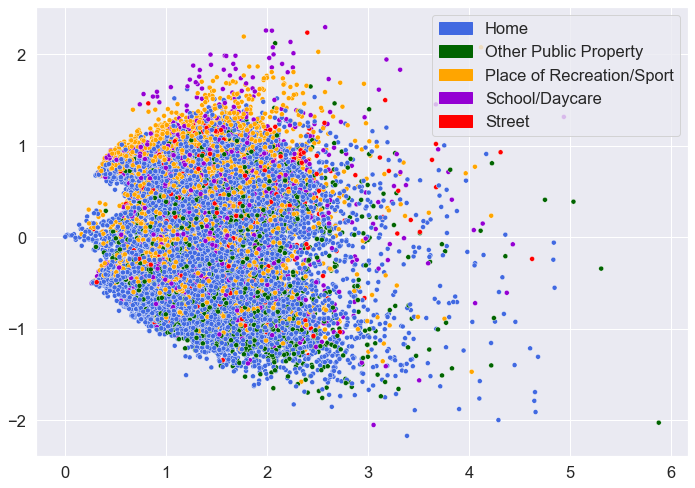

In [45]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

X_train_plot, y_train_plot, X_test_plot, y_test_plot, X_train_counts_plot, X_test_counts_plot = bow(plot_sample['Tokens'], data=plot_sample)


truncate = TruncatedSVD(n_components=2)
truncated_x = truncate.fit_transform(X_train_counts_plot)

sns.set(font_scale = 1.5)
a4_dims = (11.7, 8.27)
fig = plt.subplots(figsize=a4_dims)
colors = {0:'royalblue', 1:'darkgreen', 2:'orange', 3:'darkviolet', 4:'red'}
ax = sns.scatterplot(x=truncated_x[:, 0], y=truncated_x[:, 1], hue=y_train_plot, palette=colors, s=25)
dot1 = mpatches.Patch(color='royalblue', label='Home')
dot2 = mpatches.Patch(color='darkgreen', label='Other Public Property')
dot3 = mpatches.Patch(color='orange', label='Place of Recreation/Sport')
dot4 = mpatches.Patch(color='darkviolet', label='School/Daycare')
dot5 = mpatches.Patch(color='red', label='Street')
ax.legend(handles=[dot1, dot2, dot3, dot4, dot5])
plt.savefig('Graphs\\truncated_simple.png', bbox_inches='tight')


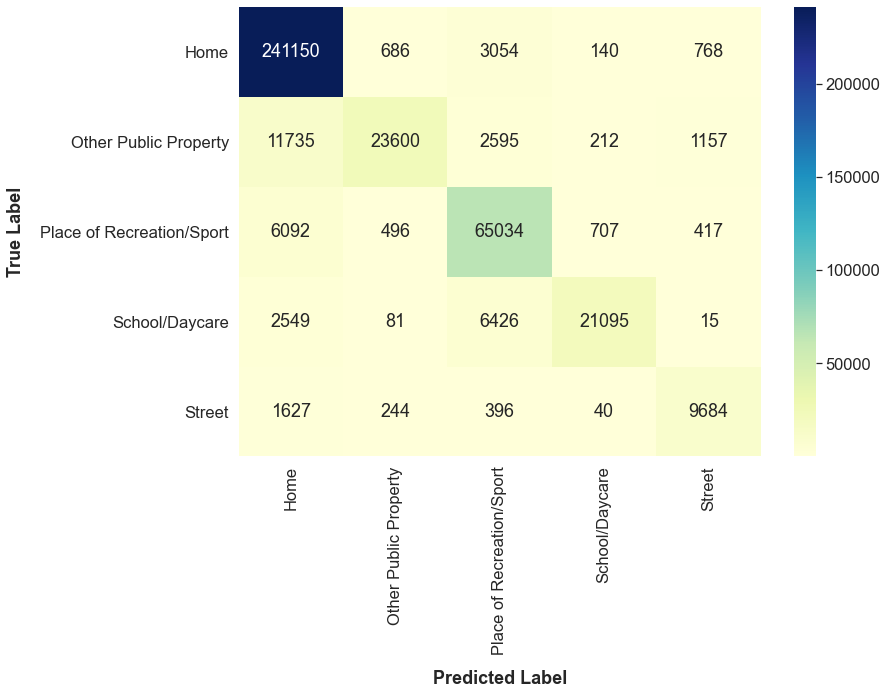

In [46]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

cm = confusion_matrix(y_train, y_pred)
labels = ['Home', 'Other Public Property', 'Place of Recreation/Sport', 'School/Daycare',
          'Street']
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])

a4_dims = (11.7, 8.27)
fig = plt.subplots(figsize=a4_dims)
sns.set(font_scale = 1.5)
ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
ax.set_ylabel('True Label', weight='bold', labelpad=15)
ax.set_xlabel('Predicted Label', weight='bold', labelpad=15)
plt.savefig('Graphs\\cm_simple.png', bbox_inches='tight')
